<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkiBhasU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Project 4: B7

# Description

In my project, I wanted to answer the question: does the player position (pos) influence the TRB in the NBA?

Despite having international popularity, basketball's most popular league is the National Basketball Association, which is primarily based in America and Canada. It's a sport in which two opposing teams (with five players at any given point of time) drive down a court attempting to score points by either shooting a three pointer or two pointer, which depends on distance from the basket. Alternatively, teams can score by drawing a foul and shooting 'free throws', which are worth one point. A rebound is the number of times a team recovers the basketball after a shot misses and hits the backboard. It allows you to 'rebound' from a missed attempt, giving a team a second shot. There are 30 teams total in the NBA, with each team playing a total of 82 games in a season.

Earlier, I mentioned there are 5 players at any time playing for a team. Each of those hold different 'positions' which take on different roles within the game: Center (C), Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF). These positions influence their statistics. Therefore, I wanted to see how their position shapes the rebounds.

# Context

For the likelihood of rebounds by position, I used the official NBA statistics for the 2023-2024 season. These values were taken from your github, so they should be trustworthy.

After choosing the data, I decided to remove all players with dual positions, as they are relatively infrequent and add too much complexity to the primary goal of finding rebounds per the original positions.

In [55]:
#import data, nothing different from the project assignment itself
base_data = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
rb_data = pd.read_csv(base_data)
#removing dual positions
rb_data = rb_data.query("Pos != 'SF-PF'")
rb_data = rb_data.query("Pos != 'PF-C'")
rb_data = rb_data.query("Pos != 'PG-SG'")
rb_data = rb_data.query("Pos != 'C-PF'")
rb_data = rb_data.query("Pos != 'PF-SF'")
rb_data = rb_data.query("Pos != 'SF-SG'")
rb_data = rb_data.query("Pos != 'SG-PG'")
rb_data = rb_data.query("MP >= 100")
#re-indexing everything
rb_data.reset_index(inplace = True, drop = True)
rb_data["Pos"] = rb_data["Pos"].astype('category')
pos_idx = rb_data.Pos.cat.codes.values
pos_codes = rb_data.Pos.cat.categories
rb_coords = {"Pos": pos_codes}
#printing the data itself
rb_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
1,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
2,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
3,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
4,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
461,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
462,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
463,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


The next thing I decided to do was create histograms of each position to see what distribution I'd need to use for my likelihood.

<Axes: xlabel='TRB', ylabel='Pos'>

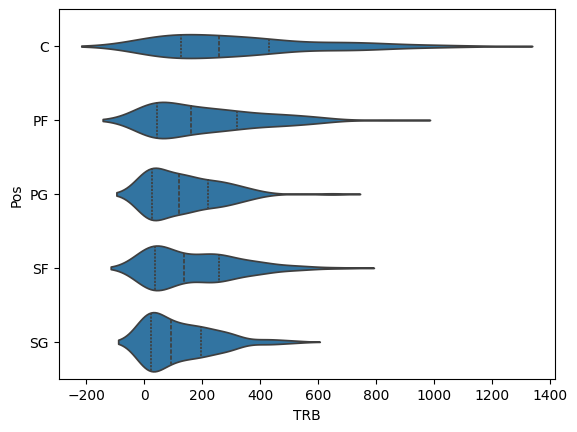

In [40]:
plotData = rb_data[["Pos", "TRB"]]
sns.violinplot(plotData, x = 'TRB', y = 'Pos', inner = 'quart')

As you can see, most of the values are centered in between 100 and 200, so the prior values will need to center there too

(array([21., 20., 13., 17.,  4.,  5.,  7.,  3.,  3.,  1.]),
 array([   0.,  112.,  224.,  336.,  448.,  560.,  672.,  784.,  896.,
        1008., 1120.]),
 <BarContainer object of 10 artists>)

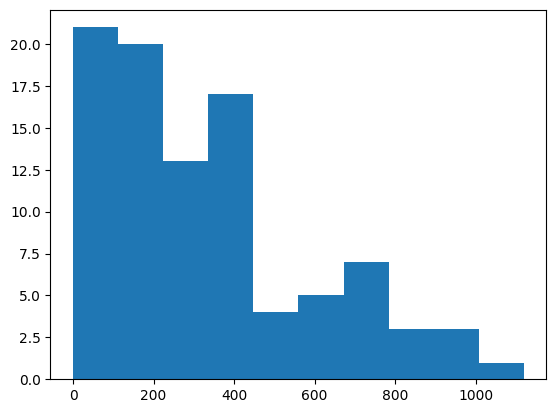

In [ ]:
plt.hist(rb_data.query("Pos == 'C'").TRB)

(array([51., 18., 17., 14., 10., 12.,  3.,  0.,  4.,  2.]),
 array([  0. ,  51.4, 102.8, 154.2, 205.6, 257. , 308.4, 359.8, 411.2,
        462.6, 514. ]),
 <BarContainer object of 10 artists>)

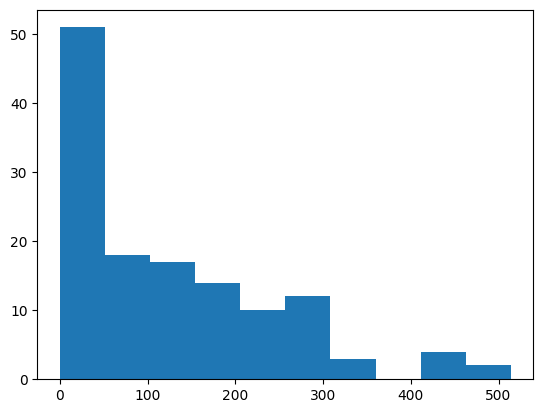

In [ ]:
plt.hist(rb_data.query("Pos == 'SG'").TRB)

(array([45., 15., 12., 20., 10.,  9.,  4.,  3.,  2.,  1.]),
 array([  0. ,  67.5, 135. , 202.5, 270. , 337.5, 405. , 472.5, 540. ,
        607.5, 675. ]),
 <BarContainer object of 10 artists>)

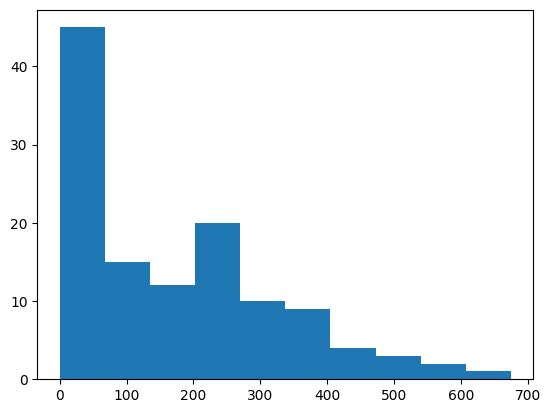

In [ ]:
plt.hist(rb_data.query("Pos == 'SF'").TRB)

(array([38., 18., 15., 12.,  9.,  8.,  5.,  3.,  0.,  1.]),
 array([  0. ,  84.1, 168.2, 252.3, 336.4, 420.5, 504.6, 588.7, 672.8,
        756.9, 841. ]),
 <BarContainer object of 10 artists>)

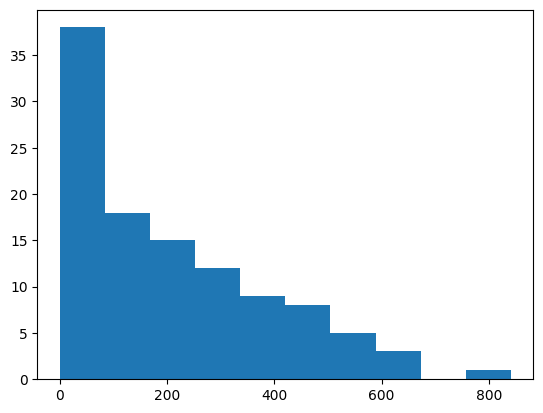

In [ ]:
plt.hist(rb_data.query("Pos == 'PF'").TRB)

(array([40., 18., 17., 11., 10.,  6.,  1.,  0.,  0.,  1.]),
 array([  0. ,  64.7, 129.4, 194.1, 258.8, 323.5, 388.2, 452.9, 517.6,
        582.3, 647. ]),
 <BarContainer object of 10 artists>)

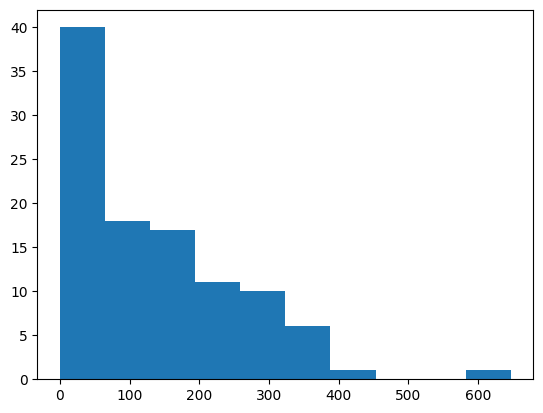

In [ ]:
plt.hist(rb_data.query("Pos == 'PG'").TRB)

For the posterior, I decided to use a Half Normal distribution to represent the TRB per position. This is because I wanted to best model the exponential decline represented on the histograms. I couldn't use other models since I wanted to ONLY include positive values, as it's impossible to have 'negative' rebounds.

# Model

In [65]:
with pm.Model(coords = rb_coords) as rb_model:
    #Hyper Parameters
    #Calculating the average mean centered around 167 with the standard deviation being the deviations of each position's respective mean, or 39
    mu_hp = pm.Normal('mμ_og', mu = 167, sigma = 39, dims = "Pos")
    #Calculating the standard deviation, with the mean being the average deviation of all positions, and the standard deviation being the deviation of each standard deviation (I used a formula calculator online)
    sigma_hp = pm.Gamma('σ_og', mu = 120, sigma = 33, dims = "Pos")
    #dims = Pos parameratizes the positions
    #mean will center around 175 because most of the values on the amino acid plot center around that
    μ = pm.Gamma('μ', mu = mu_hp, sigma = sigma_hp, dims = "Pos")
    #standard deviation is about 125, with the highest being 50 over the lowest
    σ = pm.TruncatedNormal('σ', mu = 125, sigma = 50, lower = 0, dims = "Pos")
    #I chose values for this prior such that the final model would center around 150, using the formula from the preliz documentation
    #actual model
    y = pm.Gamma('y', mu = μ[pos_idx], sigma = σ[pos_idx], observed = rb_data.TRB.values)
    idata_rb = pm.sample(target_accept = 0.95)

Output()

Output()

array([[<Axes: title={'center': 'mμ_og'}>,
        <Axes: title={'center': 'mμ_og'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_og'}>,
        <Axes: title={'center': 'σ_og'}>]], dtype=object)

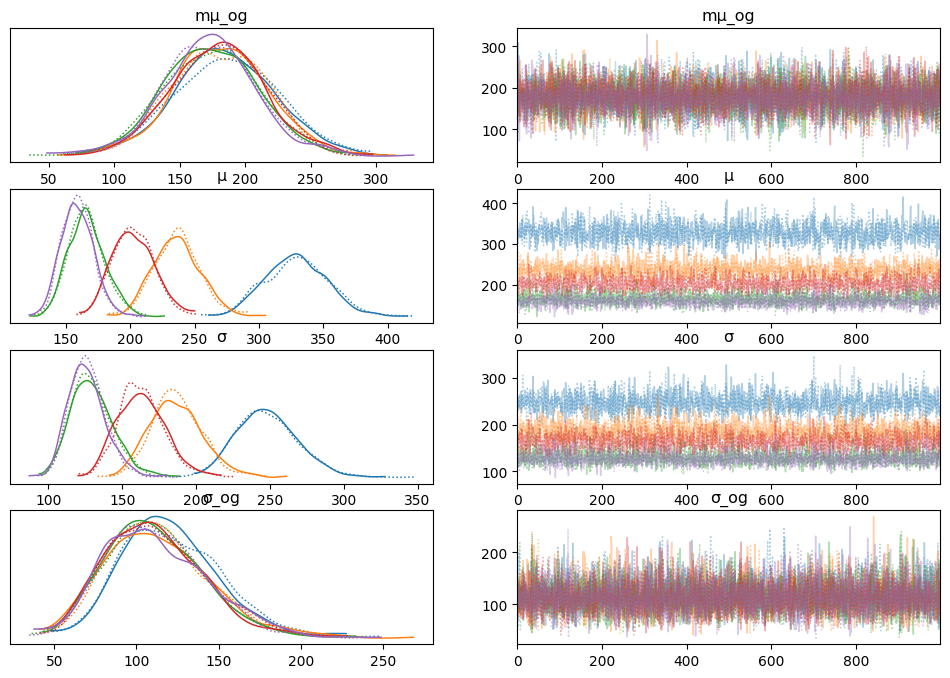

In [67]:
#still using the same code from the notes
az.plot_trace(idata_rb)

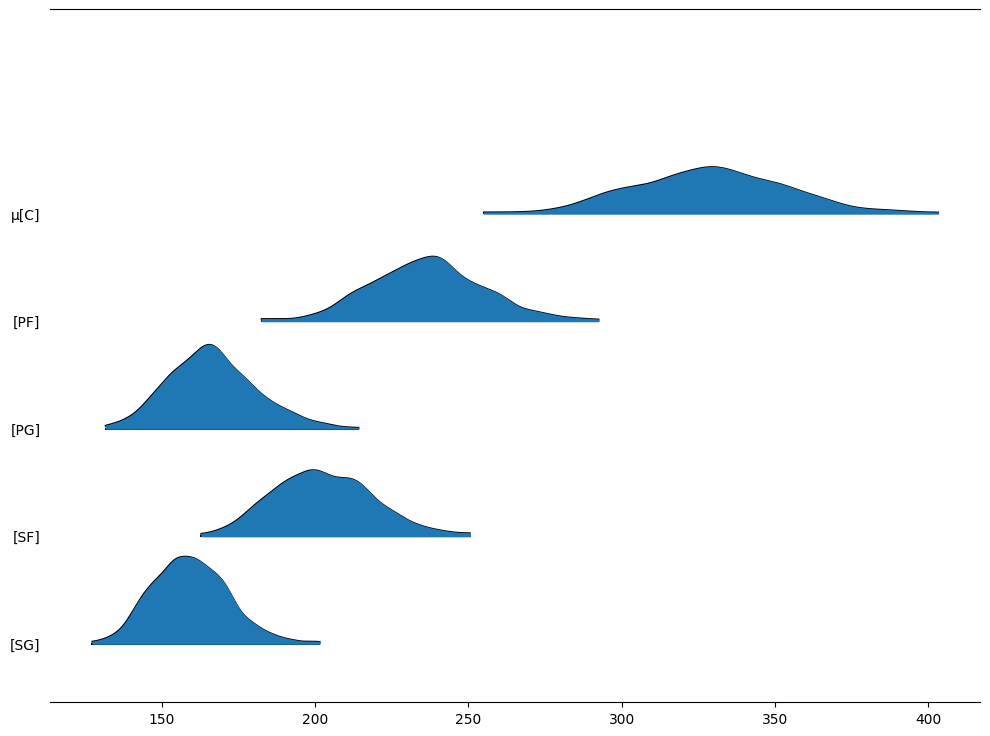

In [68]:
axes = az.plot_forest(idata_rb, kind="ridgeplot", var_names='μ', combined=True, figsize=(12, 9), hdi_prob=0.997)

Output()

<Axes: xlabel='y'>

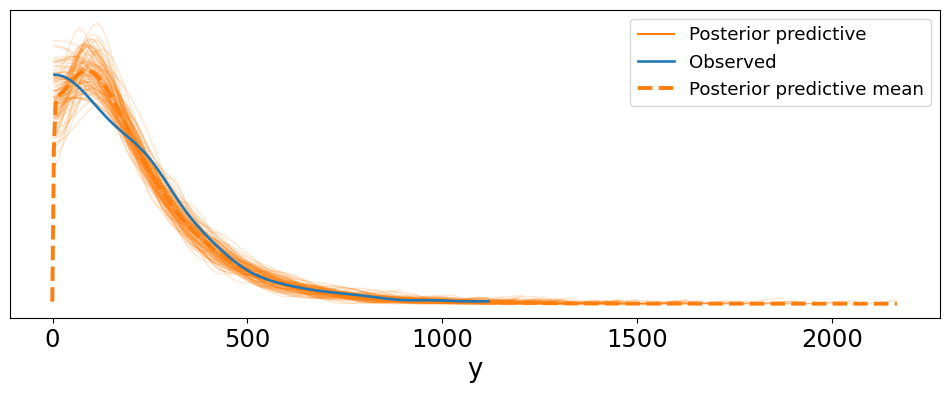

In [66]:
pm.sample_posterior_predictive(idata_rb, model=rb_model, extend_inferencedata=True)
az.plot_ppc(idata_rb, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Conclusion

Looking at the data, the model seems roughly accurate in the context of NBA basketball positions. The model nearly perfectly models the oberved data, but the highest point strays further from zero as in the observed data. To correct for this in the future, a halfNormal or halfStudentT likelihood may have been better to model the actual data. This is because both have their highest points starting from 0, and I could model them to represent a similar decline. I am relatively confident in the accuracy because the data set was very large, including all NBA players except for those that play multiple positions and those with less than a 100 minutes of play time, which removed extraneous data that may have distorted the calculations.

The data seems to match the real world. The ridgeplot indicates that the center has the highest total rebounds by position, followed by the power forward, point guard, small forward, and shooting guard.

This correlates with what I'd expect in the NBA due to each position's playstyle. The center usually stays near the box, right next to the basketball board, so it's easier for a center to get a rebound after a ball hits the basketball board. The other positions play further from the hoop, so it tracks that they have lower total rebounds because all things being equal, they're not in the position in game to recieve the ball.

The projection helps us understand the importance of the roles of NBA players. The center's job is to stay around the back board and control. Even though centers may not score as often as other positions, they're central to defend and to allow offensive momentum.
